# Estimation of missing synapses per layer

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bluepy import Circuit
from bluepy import Cell
from bluepy import Synapse

In [2]:
# Load pre-computed cell table
pkl_file = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SSCx/dendritic_synapse_density/cell_table__pokorny_SSCx_dendritic_synapse_density_SSCxO1_CircuitConfig__Target_hex_O1__2021-04-27_13-07-10.pkl'
cell_table = pd.read_pickle(pkl_file)
print(f'INFO: Loaded cell table with {cell_table.shape[0]} cells')

INFO: Loaded cell table with 211712 cells


In [3]:
# Load corresponding circuit (to access additional cell properties)
circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SSCx/dendritic_synapse_density/SSCxO1_CircuitConfig'
circuit = Circuit(circuit_config)

target_list = list(filter(lambda x: 'Target_' in x, os.path.split(pkl_file)[-1].split('__')))
circuit_target = None if len(target_list) == 0 else target_list[-1].split('Target_')[-1] # Reconstruct circuit target from pkl_file

cell_ids = circuit.cells.ids(circuit_target)
assert np.all(cell_ids == cell_table.index), 'ERROR: Cell ids mismatch!'

Using targets with population with a mvd cell file.


In [4]:
# Add total (local/TC/midrange) densities
# (incl. midrange)
# sum_columns = {'VPM_syn_density': list(filter(lambda x: 'Thalamocortical_input_VPM' in x and 'density' in x, cell_table.keys())),
#                'POM_syn_density': list(filter(lambda x: 'Thalamocortical_input_POM' in x and 'density' in x, cell_table.keys())),
#                'midrange_syn_density': ['intra_SSCX_midrange_wm_density'],
#                'total_E_syn_density': ['local_E_syn_density', 'midrange_syn_density', 'VPM_syn_density', 'POM_syn_density'],
#                'total_I_syn_density': ['local_I_syn_density']}
# (w/o midrange)
sum_columns = {'VPM_syn_density': list(filter(lambda x: 'Thalamocortical_input_VPM' in x and 'density' in x, cell_table.keys())),
               'POM_syn_density': list(filter(lambda x: 'Thalamocortical_input_POM' in x and 'density' in x, cell_table.keys())),
               'total_E_syn_density': ['local_E_syn_density', 'VPM_syn_density', 'POM_syn_density'],
               'total_I_syn_density': ['local_I_syn_density']}
for (k, v) in sum_columns.items():
    cell_table.insert(column=k, value=np.sum(cell_table[v], 1), loc=cell_table.shape[1])

In [5]:
# Commpute missing synapses
ref_density = 1.1 # syn/um [Markram et al. 2015]

cell_table.insert(column='total_E_syn_density_missing', value=ref_density - cell_table['total_E_syn_density'], loc=cell_table.shape[1])
cell_table.insert(column='local_E_syn_density_missing', value=ref_density - cell_table['local_E_syn_density'], loc=cell_table.shape[1])
cell_table.insert(column='total_E_syn_count', value=(cell_table['total_E_syn_density'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])
cell_table.insert(column='total_E_syn_count_missing', value=(cell_table['total_E_syn_density_missing'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])
cell_table.insert(column='local_E_syn_count_missing', value=(cell_table['local_E_syn_density_missing'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])

In [6]:
# Compute missing (local) EXC synapses per layer
layers = np.unique(circuit.cells.get(properties='layer'))
gids_layer = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': 'EXC'}), cell_table.index) for lay in layers]
syn_count_E_mean = [np.mean(cell_table.loc[gids_layer[i], 'local_E_syn_count_missing']) for i in range(len(layers))]
syn_count_E_std = [np.std(cell_table.loc[gids_layer[i], 'local_E_syn_count_missing']) for i in range(len(layers))]

gids_layer = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': 'INH'}), cell_table.index) for lay in layers]
syn_count_I_mean = [np.mean(cell_table.loc[gids_layer[i], 'local_E_syn_count_missing']) for i in range(len(layers))]
syn_count_I_std = [np.std(cell_table.loc[gids_layer[i], 'local_E_syn_count_missing']) for i in range(len(layers))]


In [7]:
# Define groups of rel. scaling factors
syn_count_E_mean_all_wo_L5 = np.mean(np.array(syn_count_E_mean)[[1, 2, 3, 5]])
syn_count_E_mean_L5 = np.mean(np.array(syn_count_E_mean)[4])
syn_count_I_mean_all = np.mean(syn_count_I_mean)

rel_scale_E_wo_L5 = np.round(syn_count_E_mean_all_wo_L5 / syn_count_E_mean_all_wo_L5, 1)
rel_scale_E_L5 = np.round(syn_count_E_mean_L5 / syn_count_E_mean_all_wo_L5, 1)
rel_scale_I = np.round(syn_count_I_mean_all / syn_count_E_mean_all_wo_L5, 1)

scale_dict = {                           'L1I': rel_scale_I,
              'L23E': rel_scale_E_wo_L5, 'L23I': rel_scale_I,
              'L4E': rel_scale_E_wo_L5,  'L4I': rel_scale_I, 
              'L5E': rel_scale_E_L5,     'L5I': rel_scale_I,
              'L6E': rel_scale_E_wo_L5,  'L6I': rel_scale_I}

print('##########################################')
print('### TO BE ADDED TO BBP-WORKFLOW CONFIG ###')
print('##########################################')
print('attrs: {...')
print('        "shotn_layer_scale": {}'.format(str(scale_dict).replace("'", '"')))
print('        ...}')

##########################################
### TO BE ADDED TO BBP-WORKFLOW CONFIG ###
##########################################
attrs: {...
        "shotn_layer_scale": {"L1I": 0.6, "L23E": 1.0, "L23I": 0.6, "L4E": 1.0, "L4I": 0.6, "L5E": 2.3, "L5I": 0.6, "L6E": 1.0, "L6I": 0.6}
        ...}


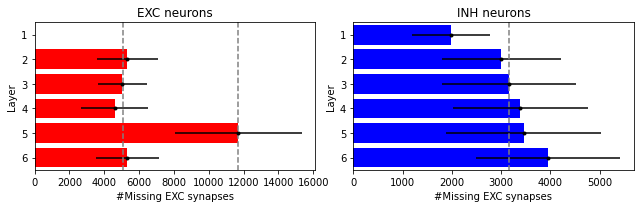

In [8]:
# Visualization of missing synapses
fig = plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.barh(layers, syn_count_E_mean, color='r')
plt.errorbar(syn_count_E_mean, layers, xerr=syn_count_E_std, fmt='.k')
plt.title('EXC neurons')
plt.xlabel('#Missing EXC synapses')
plt.ylabel('Layer')
plt.ylim((min(layers) - 0.5, max(layers) + 0.5))
plt.plot([syn_count_E_mean_all_wo_L5] * 2, plt.ylim(), '--', color='grey')
plt.plot([syn_count_E_mean_L5] * 2, plt.ylim(), '--', color='grey')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(layers, syn_count_I_mean, color='b')
plt.errorbar(syn_count_I_mean, layers, xerr=syn_count_I_std, fmt='.k')
plt.title('INH neurons')
plt.xlabel('#Missing EXC synapses')
plt.ylabel('Layer')
plt.ylim((min(layers) - 0.5, max(layers) + 0.5))
plt.plot([syn_count_I_mean_all] * 2, plt.ylim(), '--', color='grey')
plt.gca().invert_yaxis()

plt.tight_layout()

### Non-linear scaling functions
Comparison of different (converging) scaling functions $f(base\_value, scaling\_factor)$ that could be used to apply the scaling factors determined from structure e.g. to mean_pct shot noise levels without exceeding 100% depolarization.

Convergence properties:
* $f(base\_value, 1.0) \overset ! = base\_value$
* $f(base\_value, \infty) \overset ! = max\_value$


In [11]:
def plot_scaling_fct(fct_name, base_range, scale_range):
    f_scale = eval(fct_name)
    plt.figure(figsize=(6, 5))
    for base_val in base_range:
        plt.plot(scale_range, base_val * scale_range, color='grey', linewidth=0.5)
    for base_val in base_range:
        plt.plot(scale_range, [f_scale(base_val, s) for s in scale_range], label=str(base_val))
    plt.xlim((0.5, 2.5))
    plt.ylim((0, 110))
    plt.plot([1, 1], plt.ylim(), color='grey')
    plt.plot([1] * len(base_range), base_range, 'o', color='grey')
    plt.xlabel('Scaling factor')
    plt.ylabel('Scaled value')
    plt.grid(True)
    plt.title(fct_name)
    plt.legend(title='Base value', loc='lower right', ncol=2)

In [12]:
# Scaling based on bounded ~x
def f_linear_bounded(base_value, scaling_factor, max_value = 100.0):
    return np.minimum(base_value * scaling_factor, max_value)

In [13]:
# Scaling based on ~1/x
def f_inverse(base_value, scaling_factor, max_value = 100.0):
    return max_value - (max_value - base_value) / scaling_factor

In [14]:
# Scaling based on ~exp(-x)
def f_exponential(base_value, scaling_factor, max_value = 100.0):
    tau = -1 / np.log(1 - base_value / max_value)
    return max_value * (1 - np.exp(-scaling_factor / tau))

In [15]:
# Scaling based on ~tanh(x)
def f_tanh(base_value, scaling_factor, max_value = 100.0):
    tau = 1 / np.arctanh(base_value / max_value)
    return max_value * np.tanh(scaling_factor / tau)

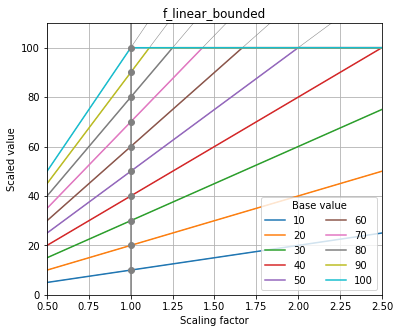

In [16]:
base_range = range(10, 110, 10)
scale_range = np.arange(0.1, 10.0, 0.01)
plot_scaling_fct('f_linear_bounded', base_range, scale_range)

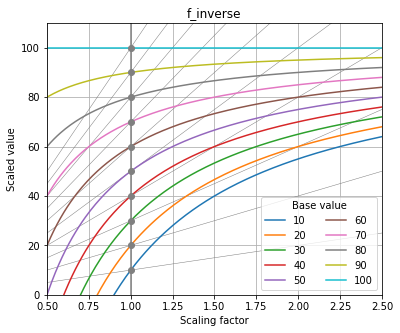

In [17]:
plot_scaling_fct('f_inverse', base_range, scale_range)

/gpfs/bbp.cscs.ch/home/pokorny/BluePy2Kernel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/gpfs/bbp.cscs.ch/home/pokorny/BluePy2Kernel/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


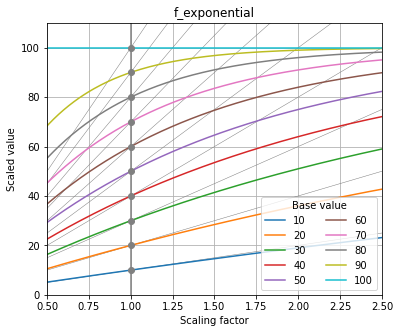

In [18]:
plot_scaling_fct('f_exponential', base_range, scale_range)

/gpfs/bbp.cscs.ch/home/pokorny/BluePy2Kernel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until
/gpfs/bbp.cscs.ch/home/pokorny/BluePy2Kernel/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


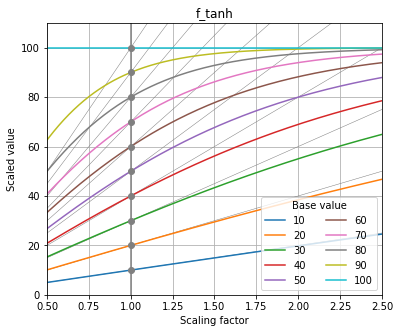

In [19]:
plot_scaling_fct('f_tanh', base_range, scale_range)

### Comparison of shot noise parameters
Comparison of scaled shot noise means/stds in a simulation campaign, using different scaling functions

In [212]:
# Baseline values of simulation campaign
depol_means = [40, 50, 60, 70, 80, 85]
depol_stds = [25, 30, 35, 40, 45]

# Reference values (from Sirio's optimization)
ref_dict = {'L1I': {'mean': 40, 'std': 30},
            'L23E': {'mean': 70, 'std': 35},
            'L23I': {'mean': 40, 'std': 30},
            'L4E': {'mean': 70, 'std': 35},
            'L4I': {'mean': 40, 'std': 30},
            'L5E': {'mean': 70, 'std': 43},
            'L5I': {'mean': 40, 'std': 30},
            'L6E': {'mean': 70, 'std': 30},
            'L6I': {'mean': 40, 'std': 30}}

# Settings
f_none = lambda base, scale: base
f_linear = lambda base, scale: base * scale
# scale_fcts = {'mean': f_none, 'std': f_linear}
scale_fcts = {'mean': f_exponential, 'std': f_none}
# scale_fcts = {'mean': f_exponential, 'std': f_exponential}
layer_keys = sorted(scale_dict.keys())

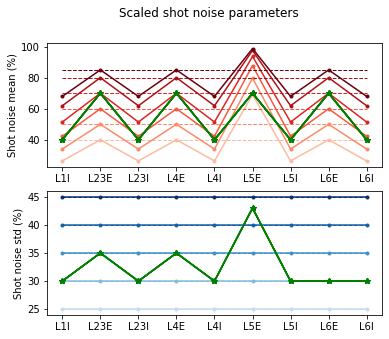

In [214]:
# Plot scaled depol values (per layer)
plt.figure(figsize=(6, 5))
plt.subplot(2, 1, 1)
mean_colors = plt.cm.Reds(np.linspace(0.25, 1, len(depol_means)))
for m_idx, depol_mean in enumerate(depol_means):
    scaled_means = [scale_fcts['mean'](depol_mean, scale_dict[k]) for k in layer_keys]
    plt.plot(range(len(layer_keys)), [depol_mean] * len(layer_keys), '--', color=mean_colors[m_idx], linewidth=1) # Baseline
    plt.plot(range(len(layer_keys)), scaled_means, '.-', color=mean_colors[m_idx]) # Scaled values
    plt.plot(range(len(layer_keys)), [ref_dict[k]['mean'] for k in layer_keys], '*-', color='g') # Ref values
    plt.gca().set_xticks(range(len(layer_keys)))
    plt.gca().set_xticklabels(layer_keys)
plt.ylabel('Shot noise mean (%)')

plt.subplot(2, 1, 2)
std_colors = plt.cm.Blues(np.linspace(0.25, 1, len(depol_stds)))
for s_idx, depol_std in enumerate(depol_stds):
    scaled_stds = [scale_fcts['std'](depol_std, scale_dict[k]) for k in layer_keys]
    plt.plot(range(len(layer_keys)), [depol_std] * len(layer_keys), '--', color=std_colors[s_idx], linewidth=1) # Baseline
    plt.plot(range(len(layer_keys)), scaled_stds, '.-', color=std_colors[s_idx]) # Scaled values
    plt.plot(range(len(layer_keys)), [ref_dict[k]['std'] for k in layer_keys], '*-', color='g') # Ref values
    plt.gca().set_xticks(range(len(layer_keys)))
    plt.gca().set_xticklabels(layer_keys)
plt.ylabel('Shot noise std (%)')

plt.suptitle('Scaled shot noise parameters')
plt.show()